In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Preparing Data for SVM Algorithm

In order to make the data suitable for the SVM algorithm, it needs to be preprocessed. The textual data or student features are converted into numerical format. The `get_dummies()` method from the Pandas library is used to encode categorical columns. Each column is split into multiple columns, and binary values (0 or 1) are assigned based on whether a student possesses a particular feature.

For example, the 'gender' column is split into two columns: 'gender_male' and 'gender_female'. A student receives a 0 in 'gender_male' and a 1 in 'gender_female' if they are female, and vice versa for males. This process is repeated for each relevant column. 

The three result columns are then collapsed into a single column with values of 1 (passed) or -1 (failed).

Next, the `train_test_split()` method from the scikit-learn library is used to divide the dataset into training and testing sets. The method randomly selects 80% of the rows for the training set and the remaining 20% for the test set. The training set is used to train the SVM model, and the test set is used to evaluate the model's performance.

Example of how the train set looks like:

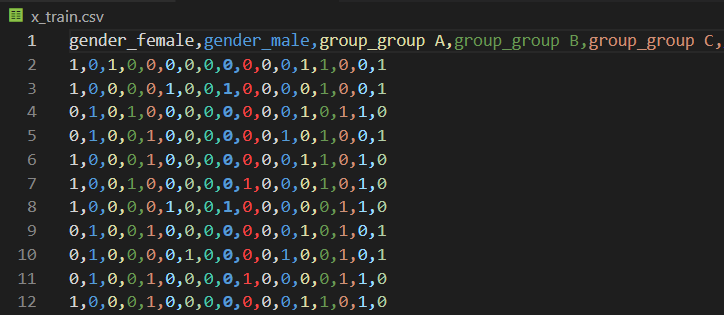

In [6]:
def initialize_dataset(input_file: str) -> tuple:

    dataframe = pd.read_csv(input_file)
    cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
    pre = ['gender', 'group', 'parent_ed', 'lunch', 'prep_course']
    dataframe  = pd.get_dummies(dataframe , columns=cols, prefix=pre, dtype=int)

    # Convert score columns to integers
    dataframe[['math score', 'reading score', 'writing score']] = dataframe[['math score', 'reading score', 'writing score']].astype(int)

    # Create a new column 'passed' based on your condition
    dataframe['passed'] = dataframe.apply(lambda row: 1 if (row['math score'] > 60) & (row['reading score'] > 60) & (row['writing score'] > 60) else -1, axis=1)
    dataframe.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)

    x_train, x_test, y_train, y_test = tts(dataframe.drop(['passed'], axis=1), dataframe['passed'], test_size=0.2, random_state=42)

    return (x_train.to_numpy(), y_train.to_numpy(), x_test.to_numpy(), y_test.to_numpy())

**Custom Exception: KernelNotSupported**

In the context of this code, a custom exception named `KernelNotSupported` is defined. This exception is raised when a specified kernel is not supported by the model.

- **kernel:** The unsupported kernel type that triggered the exception.

The exception provides a human-readable error message through the `message` attribute, stating that the specified kernel is not supported. Currently, only linear and rbf (Radial Basis Function) kernels are supported by this model.

In [4]:
class KernelNotSupported(Exception):
    def __init__(self, kernel):
        self.kernel = kernel
        self.message = "Kernel {} is not supported by this model, only linear and rbf are supported".format(self.kernel)

## Implementation of SVM - Dual Problem Formulation

**Initializing the SVM Model:**
- **`kernel:`** The kernel type determines the nature of the decision boundary. Currently, only 'linear' and 'rbf' kernels are supported.
- **`C:`** The regularization parameter controls the trade-off between achieving a smooth decision boundary and classifying training points correctly. Higher values result in a more complex model, potentially prone to overfitting.
- **`gamma:`** Applicable only for 'rbf' kernels, gamma defines the influence of individual training samples. Higher values lead to a more intricate model, susceptible to overfitting.

Default values for **`C`** and **`gamma`** are set to **1.0** and **0.7**, respectively, based on optimal performance observed in experiments.

**Kernels:**
- **`linear:`** This kernel is utilized when the data is linearly separable. It is computationally efficient and straightforward.

    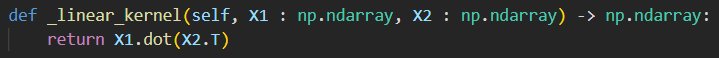

- **`rbf:`** The Radial Basis Function (RBF) kernel is chosen when the data isn't linearly separable. The implementation incorporates **`np.newaxis`** to ensure accurate computations, especially when working with vectors of varying dimensions.

    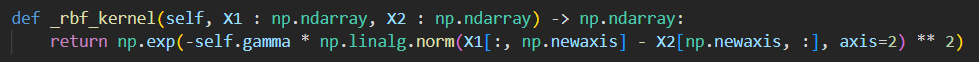

**Training the Model:**
- The **`fit()`** method is employed for training, requiring **`X`** and **`y`** as main parameters (training data and labels). Optionally, **`C`** and **`gamma`** can be specified. Setting **`draw`** to **True** visualizes the hinge loss function plot during training.

- Initialization includes a random **`alpha`** vector and a float **`b`** (bias) from a normal distribution (mean=0, std=1).

- Before training, the **`kernel * y * y`** is computed; a fixed value for a given training set, saving computational time.

    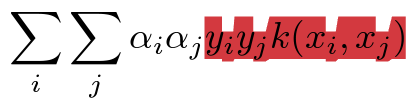

- Minimization is achieved through stochastic gradient descent. Parameters like the learning rate and epochs are customizable. The gradient used is:

    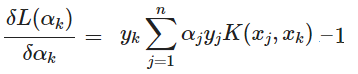

- Updating **`alpha`** follows the gradient and learning rate. Bounds are enforced (between 0 and **`C`**). Additionally, the gradient is adjusted with **`y^T * alpha`** to adhere to constraints.

- Hinge loss is calculated and appended to the losses list after each loop.

    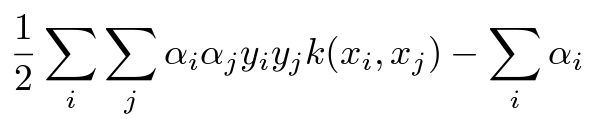

- Convergence is assessed using the formula:

    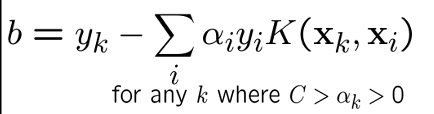

**Predicting Labels:**
- The **`predict()`** method forecasts labels for the test set (**`X`**), returning a list of predicted labels.

    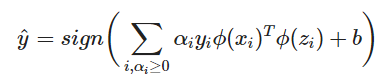


In [55]:
class MySVM:
    def __init__(self, C=0.5, kernel='rbf', gamma=0.1):
        self.C = C

        if kernel == 'linear':
            self.kernel = self._linear_kernel
        elif kernel == 'rbf':
            self.kernel = self._rbf_kernel
            self.gamma = gamma
        else:
            raise KernelNotSupported(kernel)

        self.X = None
        self.y = None
        self.alpha = None
        self.b = 0
        self.ones = None

    def _rbf_kernel(self, X1 : np.ndarray, X2 : np.ndarray) -> np.ndarray:
        return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)

    def _linear_kernel(self, X1 : np.ndarray, X2 : np.ndarray) -> np.ndarray:
        return X1.dot(X2.T)

    def fit(self, X : np.ndarray, y : np.ndarray, lr : float = 1e-5, epochs : int = 1000, draw : bool = False) -> None:

        self.X = X
        self.y = y

        self.alpha = np.random.uniform(0, 1, X.shape[0])
        self.b = np.random.uniform(0, 1)
        self.ones = np.ones(X.shape[0])

        y_kernel = np.outer(y, y) * self.kernel(X, X)

        losses = []
        for _ in range(epochs):
            # calculating gradient
            gradient = y_kernel.dot(self.alpha) - self.ones

            # adding the y^T * a_i = 0 constraint
            gradient += np.sum(y * self.alpha)

            # updating alpha
            self.alpha = self.alpha - lr * gradient

            # prunning alfa values to [0, C]
            self.alpha = np.clip(self.alpha, 0, self.C)

            # calculating loss
            loss = 0.5 * np.sum(np.outer(self.alpha, self.alpha) * y_kernel) - np.sum(self.alpha)
            losses.append(loss)

        index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]
        b_i = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))
        self.b = np.mean(b_i)

        if draw:
            plt.plot(losses)
            plt.title("loss per epochs")
            plt.show()

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.sign((self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b)

## Testing the Model

I compare my own implementation of a Support Vector Machine (SVM) classifier with the implementation available in the scikit-learn library. The analysis is conducted on a dataset loaded from the "dataset.csv" file. I use sklearn's methods to check the performance of my model. 

- **`accuracy_score()`** is used to calculate the accuracy of the model. It checks the number of correct predictions made by the model and returns the accuracy score as a float value ranging from 0 to 1. The higher the value, the better the model's performance.

- **`confusion_matrix()`** is used to calculate the confusion matrix. It returns a 2D array of the form:
 [[true_positive, false_negative], 
 [false_positive, true_negative]]. 
 The rows represent the actual labels, and the columns represent the predicted labels. The diagonal elements of the matrix represent the number of correct predictions, and the off-diagonal elements represent the number of incorrect predictions.

- **`precision_score()`** Precision for SVM performance measures the accuracy of the positive predictions made by the classifier. It indicates the proportion of correctly identified positive instances among all instances predicted as positive by the SVM. A high precision suggests that when the SVM predicts a positive class, it is often correct.

- **`recall_score()`** Recall for SVM performance measures the classifier's ability to capture all positive instances in the dataset. It indicates the proportion of correctly identified positive instances among all actual positive instances. High recall implies that the SVM is effective at identifying most of the positive instances in the dataset.

The results for both implementations are comparable, indicating the correctness of my own SVM classifier implementation. Analyzing metrics helps understand in which areas the classifier may be more or less effective.

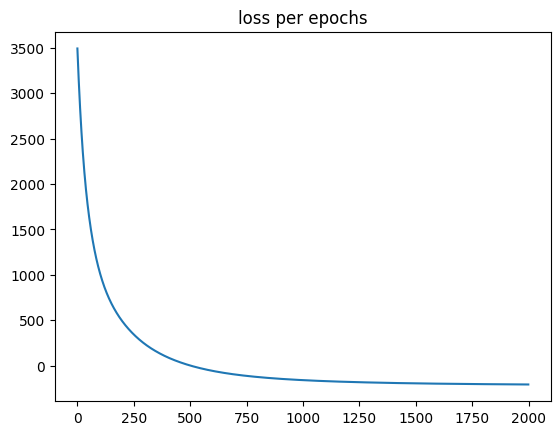

My linear accuracy: 0.66
My linear precision: 0.7352941176470589
My linear recall: 0.646551724137931
My linear confusion Matrix:
 [[57 27]
 [41 75]]
Lib linear accuracy: 0.69
Lib linear precision: 0.6956521739130435
Lib linear recall: 0.8275862068965517
Lib linear confusion Matrix:
 [[42 42]
 [20 96]]


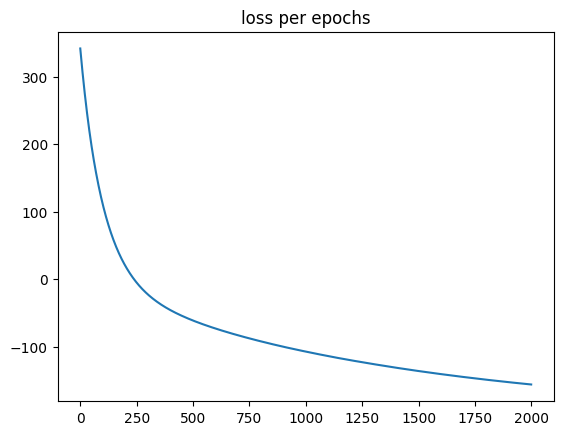

My rbf accuracy: 0.67
My rbf precision: 0.711864406779661
My rbf recall: 0.7241379310344828
My rbf confusion Matrix:
 [[50 34]
 [32 84]]
Lib rbf accuracy: 0.7
Lib rbf precision: 0.6971830985915493
Lib rbf recall: 0.853448275862069
Lib rbf confusion Matrix:
 [[41 43]
 [17 99]]


In [50]:
x_train, y_train, x_test, y_test = initialize_dataset("dataset.csv")

svm = MySVM(C=0.5, kernel='linear')
svm.fit(x_train, y_train, lr=1e-5, epochs=2000, draw=True)
prediction = svm.predict(x_test)

print("My linear accuracy:", accuracy_score(prediction, y_test))
print("My linear precision:", precision_score(y_test, prediction))
print("My linear recall:", recall_score(y_test, prediction))
print("My linear confusion Matrix:\n", confusion_matrix(y_test, prediction))

lib_svm = SVC(C=0.5, kernel='linear', max_iter=2000)
lib_svm.fit(x_train, y_train)
prediction = lib_svm.predict(x_test)

print("Lib linear accuracy:", accuracy_score(prediction, y_test))
print("Lib linear precision:", precision_score(y_test, prediction))
print("Lib linear recall:", recall_score(y_test, prediction))
print("Lib linear confusion Matrix:\n", confusion_matrix(y_test, prediction))

svm = MySVM(C=0.5, kernel='rbf', gamma=0.1)
svm.fit(x_train, y_train, lr=1e-5, epochs=2000, draw=True)
prediction = svm.predict(x_test)

print("My rbf accuracy:", accuracy_score(prediction, y_test))
print("My rbf precision:", precision_score(y_test, prediction))
print("My rbf recall:", recall_score(y_test, prediction))
print("My rbf confusion Matrix:\n", confusion_matrix(y_test, prediction))

lib_svm = SVC(C=0.5, kernel='rbf', gamma=0.1, max_iter=2000)
lib_svm.fit(x_train, y_train)
prediction = lib_svm.predict(x_test)

print("Lib rbf accuracy:", accuracy_score(prediction, y_test))
print("Lib rbf precision:", precision_score(y_test, prediction))
print("Lib rbf recall:", recall_score(y_test, prediction))
print("Lib rbf confusion Matrix:\n", confusion_matrix(y_test, prediction))

In [56]:
def run_svm_and_average(model, x_train, y_train, x_test, y_test, num_runs=10):
    scores = {'accuracy': [], 'precision': [], 'recall': []}

    for _ in range(num_runs):
        model.fit(x_train, y_train)
        prediction = model.predict(x_test)

        scores['accuracy'].append(accuracy_score(prediction, y_test))
        scores['precision'].append(precision_score(prediction, y_test))
        scores['recall'].append(recall_score(prediction, y_test))

    average_scores = {
        'accuracy': np.mean(scores['accuracy']),
        'precision': np.mean(scores['precision']),
        'recall': np.mean(scores['recall'])
    }

    return average_scores

In [59]:
def draw_graphs():
    c = np.linspace(0.001, 1.5, 30)
    input_file = "dataset.csv"
    x_train, y_train, x_test, y_test = initialize_dataset(input_file)

    fig, axs = plt.subplots(3, 1, figsize=(8, 12))

    kernels = ['linear', 'rbf']
    metrics = ['Accuracy', 'Precision', 'Recall']

    for kernel in kernels:
        my_acc = []
        my_prec = []
        my_rec = []
        lib_acc = []
        lib_prec = []
        lib_rec = []

        for i in c:
            my_svm = MySVM(kernel=kernel, C=i, gamma=0.1)
            my_scores = run_svm_and_average(my_svm, x_train, y_train, x_test, y_test, num_runs=10)
            my_acc.append(my_scores['accuracy'])
            my_prec.append(my_scores['precision'])
            my_rec.append(my_scores['recall'])

            lib_svc = SVC(kernel=kernel, C=i, gamma=0.1, max_iter=1000)
            lib_scores = run_svm_and_average(lib_svc, x_train, y_train, x_test, y_test, num_runs=10)
            lib_acc.append(lib_scores['accuracy'])
            lib_prec.append(lib_scores['precision'])
            lib_rec.append(lib_scores['recall'])

        # Plot accuracy
        axs[0].plot(c, my_acc, label=f'My {kernel} accuracy')
        axs[0].plot(c, lib_acc, label=f'Lib {kernel} accuracy')

        # Plot precision
        axs[1].plot(c, my_prec, label=f'My {kernel} precision')
        axs[1].plot(c, lib_prec, label=f'Lib {kernel} precision')

        # Plot recall
        axs[2].plot(c, my_rec, label=f'My {kernel} recall')
        axs[2].plot(c, lib_rec, label=f'Lib {kernel} recall')

    for ax, metric in zip(axs, metrics):
        ax.set_xlabel('C value')
        ax.set_ylabel(metric)
        ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plots
    plt.show()


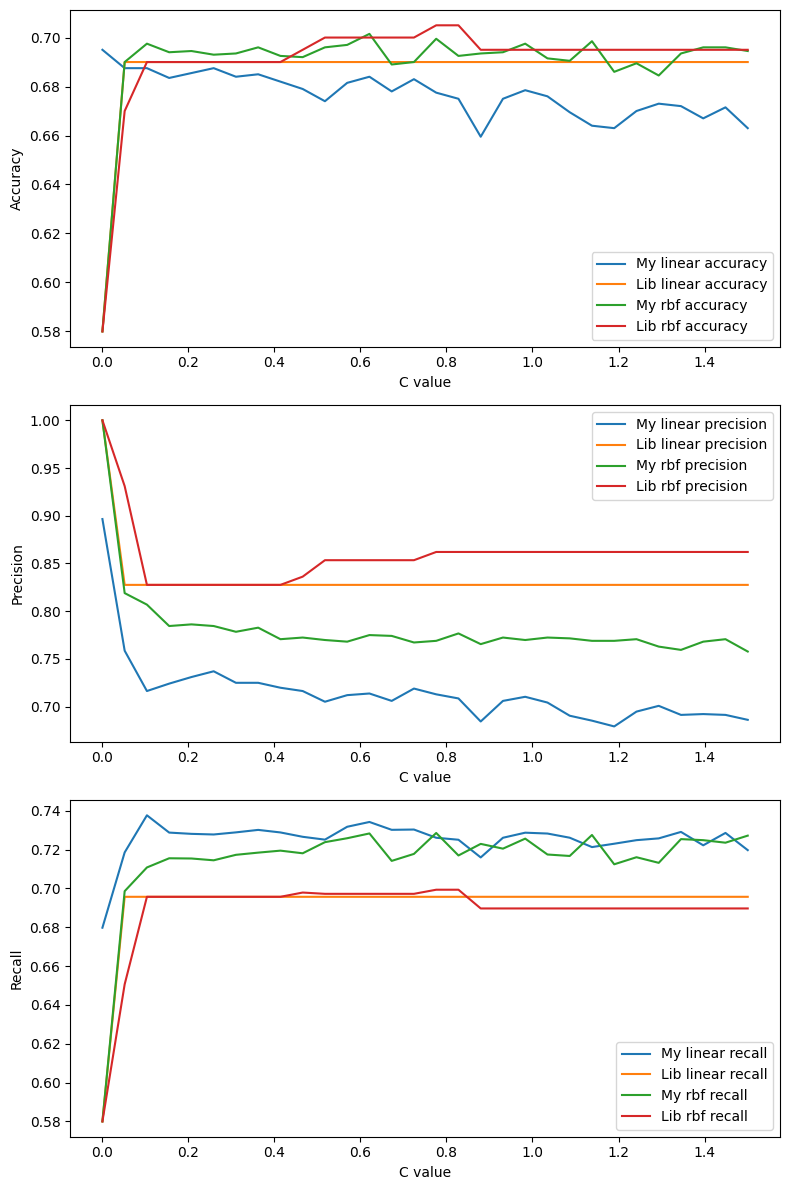

In [60]:
draw_graphs()